In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/supermarket-dataset/().xlsx


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

## Data Loading and Exploration

In [69]:
# Load data
df = pd.read_excel('/kaggle/input/supermarket-dataset/().xlsx')

# Display basic information about the dataset
print("Dataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nFirst 5 Rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Category           9994 non-null   object        
 1   City               9994 non-null   object        
 2   Country            9994 non-null   object        
 3   Customer Name      9994 non-null   object        
 4   Manufacturer       9994 non-null   object        
 5   Order Date         9994 non-null   datetime64[ns]
 6   Order ID           9994 non-null   object        
 7   Postal Code        9994 non-null   int64         
 8   Product Name       9994 non-null   object        
 9   Region             9994 non-null   object        
 10  Segment            9994 non-null   object        
 11  Ship Date          9994 non-null   datetime64[ns]
 12  Ship Mode          9994 non-null   object        
 13  State              9994 non-null   object        

## Feature Engineering

In [70]:
# Clean the Profit and Sales column to ensure they're numeric
# Remove dollar signs and convert to float
df['Sales'] = df['Sales'].replace(r'[\$,]', '', regex=True).astype(float)
df['Profit'] = df['Profit'].replace(r'[\$,]', '', regex=True).astype(float)

In [71]:
# Create new features: Recency (days since last order), Frequency (number of orders per customer), Monetary (total sales per customer)
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])
latest_date = df['Order Date'].max()
print("\nLatest Order Date:", latest_date)


Latest Order Date: 2016-12-30 00:00:00


In [72]:
# Create Recency at the transaction level
df['Recency'] = (latest_date - df['Order Date']).dt.days
print("\nDataFrame with Recency Column (First 5 Rows):")
print(df[['Customer Name', 'Order Date', 'Recency']].head())


DataFrame with Recency Column (First 5 Rows):
   Customer Name Order Date  Recency
0  Darren Powers 2013-01-03     1457
1  Phillina Ober 2013-01-04     1456
2  Phillina Ober 2013-01-04     1456
3  Phillina Ober 2013-01-04     1456
4     Mick Brown 2013-01-05     1455


In [73]:
# Aggregate customer-level features
customer_agg = df.groupby('Customer Name').agg({
    'Order ID': 'count',  # Frequency
    'Sales': 'sum',       # Monetary
    'Recency': 'min'      # Most recent purchase
}).rename(columns={'Order ID': 'Frequency', 'Sales': 'Monetary'})
customer_agg.reset_index(inplace=True)
print("\nCustomer Aggregated Data (First 5 Rows):")
print(customer_agg.head())


Customer Aggregated Data (First 5 Rows):
     Customer Name  Frequency  Monetary  Recency
0    Aaron Bergman          6     887.0      415
1    Aaron Hawkins         11    1744.0       12
2   Aaron Smayling         10    3051.0       88
3  Adam Bellavance         18    7757.0       54
4        Adam Hart         20    3251.0       34


In [74]:
# Merge aggregated features back to the original dataframe
df = df.merge(customer_agg[['Customer Name', 'Frequency', 'Monetary', 'Recency']], on='Customer Name', how='left', suffixes=('', '_agg'))
print("\nDataFrame After Merge (First 5 Rows):")
print(df[['Customer Name', 'Recency', 'Recency_agg', 'Frequency', 'Monetary']].head())


DataFrame After Merge (First 5 Rows):
   Customer Name  Recency  Recency_agg  Frequency  Monetary
0  Darren Powers     1457          126         17    1051.0
1  Phillina Ober     1456           86         10    1057.0
2  Phillina Ober     1456           86         10    1057.0
3  Phillina Ober     1456           86         10    1057.0
4     Mick Brown     1455           44         10    1429.0


In [75]:
# Select features for clustering
features = ['Recency_agg', 'Frequency', 'Monetary', 'Quantity', 'Profit', 'Discount']
categorical_features = ['Category', 'Region', 'Sub-Category']

In [76]:
# Encode categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df[col + '_Encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    features.append(col + '_Encoded')

In [77]:
# Create a copy of the dataframe for hyperparameter tuning
df_copy = df.copy()

In [78]:
# Verify features exist in DataFrame
print("\nAvailable Columns in DataFrame:")
print(df.columns.tolist())
print("\nSelected Features for Clustering:")
print(features)


Available Columns in DataFrame:
['Category', 'City', 'Country', 'Customer Name', 'Manufacturer', 'Order Date', 'Order ID', 'Postal Code', 'Product Name', 'Region', 'Segment', 'Ship Date', 'Ship Mode', 'State', 'Sub-Category', 'Discount', 'Number of Records', 'Profit', 'Profit Ratio', 'Quantity', 'Sales', 'Recency', 'Frequency', 'Monetary', 'Recency_agg', 'Category_Encoded', 'Region_Encoded', 'Sub-Category_Encoded']

Selected Features for Clustering:
['Recency_agg', 'Frequency', 'Monetary', 'Quantity', 'Profit', 'Discount', 'Category_Encoded', 'Region_Encoded', 'Sub-Category_Encoded']


In [80]:
# Scale numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled_features, columns=features)

In [81]:
# Display the scaled dataframe
print("\nScaled Features for Clustering:")
print(scaled_df.head())


Scaled Features for Clustering:
   Recency_agg  Frequency  Monetary  Quantity    Profit  Discount  \
0     0.036936   0.196702 -0.896076 -0.804303 -0.096702  0.212153   
1    -0.221406  -0.855192 -0.893962 -0.354865 -0.105240  0.212153   
2    -0.221406  -0.855192 -0.893962 -0.354865 -0.399805  0.212153   
3    -0.221406  -0.855192 -0.893962 -0.804303 -0.143662  3.118544   
4    -0.492666  -0.855192 -0.762878 -0.354865 -0.100971  0.212153   

   Category_Encoded  Region_Encoded  Sub-Category_Encoded  
0          0.043552       -1.351357              0.872974  
1          0.043552       -1.351357              0.477027  
2          0.043552       -1.351357              1.268921  
3          0.043552       -1.351357             -0.908789  
4          0.043552       -0.490972             -1.106763  


**Observations:**

- **Outliers:** The Monetary value for Adam Bellavance (7757) is much higher than others (e.g., $887 for Aaron Bergman), which suggests potential outliers in spending behavior.
- **Recency Variation:** Customers like Aaron Hawkins (12 days) are very recent buyers, while Aaron Bergman (415 days) is less active, which could form distinct clusters.
- **Categorical Features:** The encoded categorical features show variation (e.g., -1.351357 vs. -0.490972). This underlines regional differences that may influence clustering.

## Exploratory Data Analysis

In [82]:
# Set plot style for better visualization
plt.style.use('seaborn')
sns.set_palette('husl')

In [83]:
# Summary statistics for numerical features
print("Summary Statistics for Numerical Features:")
print(df[['Recency_agg', 'Frequency', 'Monetary', 'Quantity', 'Profit', 'Discount']].describe())

Summary Statistics for Numerical Features:
       Recency_agg    Frequency      Monetary     Quantity       Profit  \
count  9994.000000  9994.000000   9994.000000  9994.000000  9994.000000   
mean    120.281069    15.691015   3593.956274     3.789574    28.651891   
std     154.841098     6.654997   2838.021830     2.225110   234.255712   
min       0.000000     1.000000      5.000000     1.000000 -6600.000000   
25%      28.000000    11.000000   1669.000000     2.000000     2.000000   
50%      60.000000    15.000000   2873.500000     3.000000     9.000000   
75%     146.000000    20.000000   4714.000000     5.000000    29.000000   
max    1165.000000    37.000000  25042.000000    14.000000  8400.000000   

          Discount  
count  9994.000000  
mean      0.156203  
std       0.206452  
min       0.000000  
25%       0.000000  
50%       0.200000  
75%       0.200000  
max       0.800000  


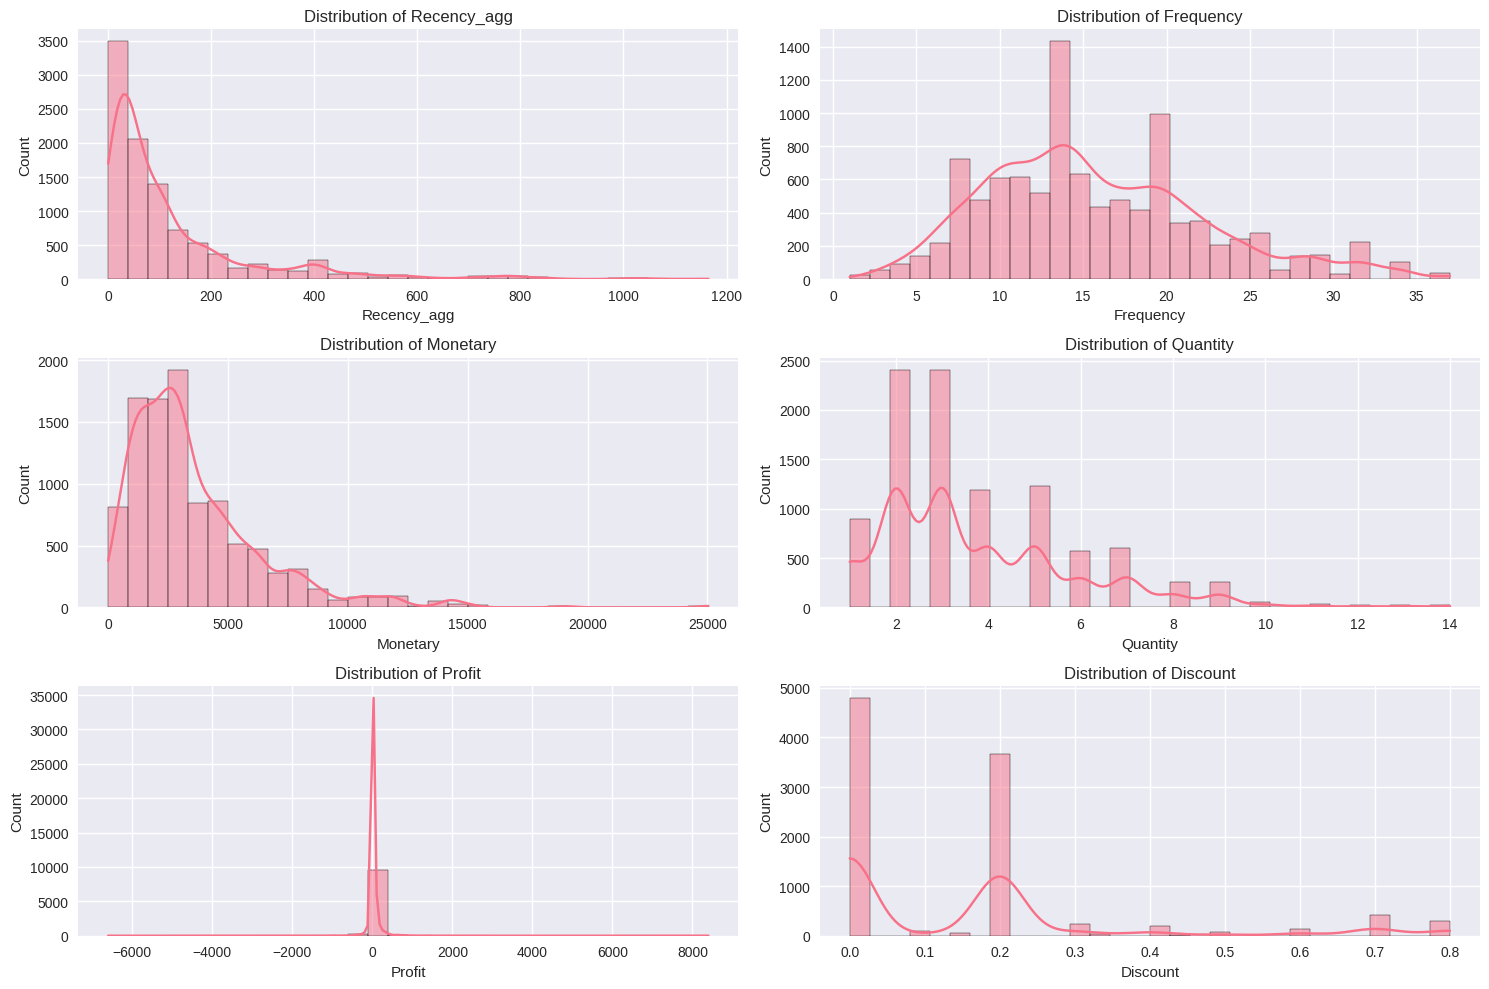

In [84]:
# Distribution of Numerical Features
numerical_features = ['Recency_agg', 'Frequency', 'Monetary', 'Quantity', 'Profit', 'Discount']
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

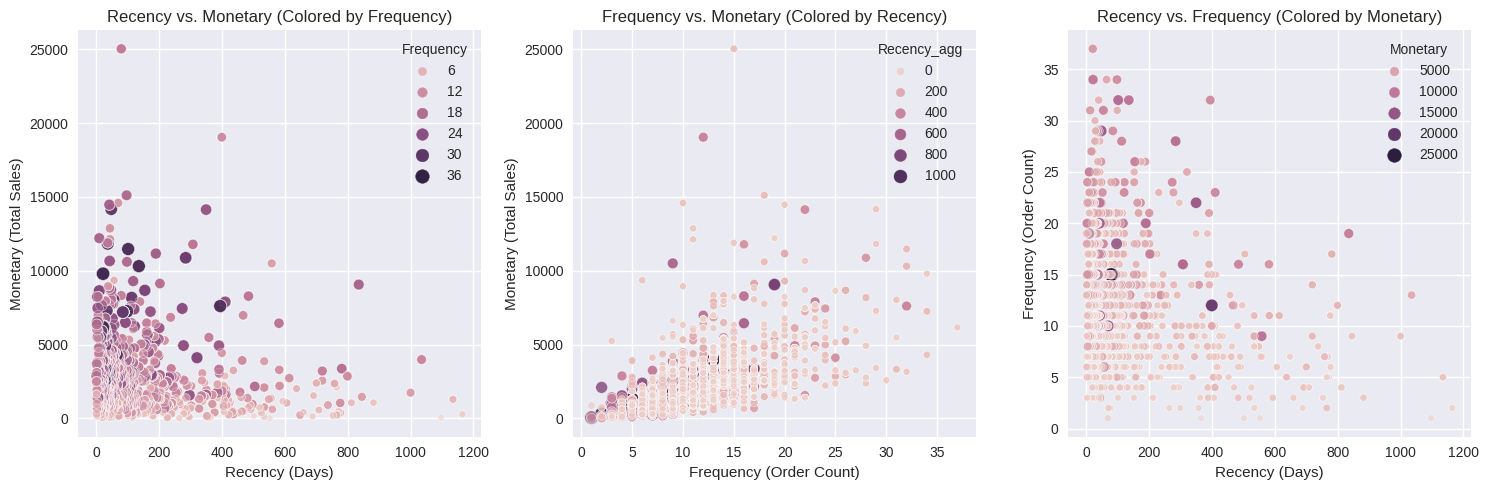

In [87]:
# 2. Scatter Plots for RFM Features
plt.figure(figsize=(15, 5))

# Recency vs. Monetary
plt.subplot(1, 3, 1)
sns.scatterplot(data=df, x='Recency_agg', y='Monetary', hue='Frequency', size='Frequency', alpha=0.6)
plt.title('Recency vs. Monetary (Colored by Frequency)')
plt.xlabel('Recency (Days)')
plt.ylabel('Monetary (Total Sales)')

# Frequency vs. Monetary
plt.subplot(1, 3, 2)
sns.scatterplot(data=df, x='Frequency', y='Monetary', hue='Recency_agg', size='Recency_agg', alpha=0.6)
plt.title('Frequency vs. Monetary (Colored by Recency)')
plt.xlabel('Frequency (Order Count)')
plt.ylabel('Monetary (Total Sales)')

# Recency vs. Frequency
plt.subplot(1, 3, 3)
sns.scatterplot(data=df, x='Recency_agg', y='Frequency', hue='Monetary', size='Monetary', alpha=0.6)
plt.title('Recency vs. Frequency (Colored by Monetary)')
plt.xlabel('Recency (Days)')
plt.ylabel('Frequency (Order Count)')

plt.tight_layout()
plt.show()

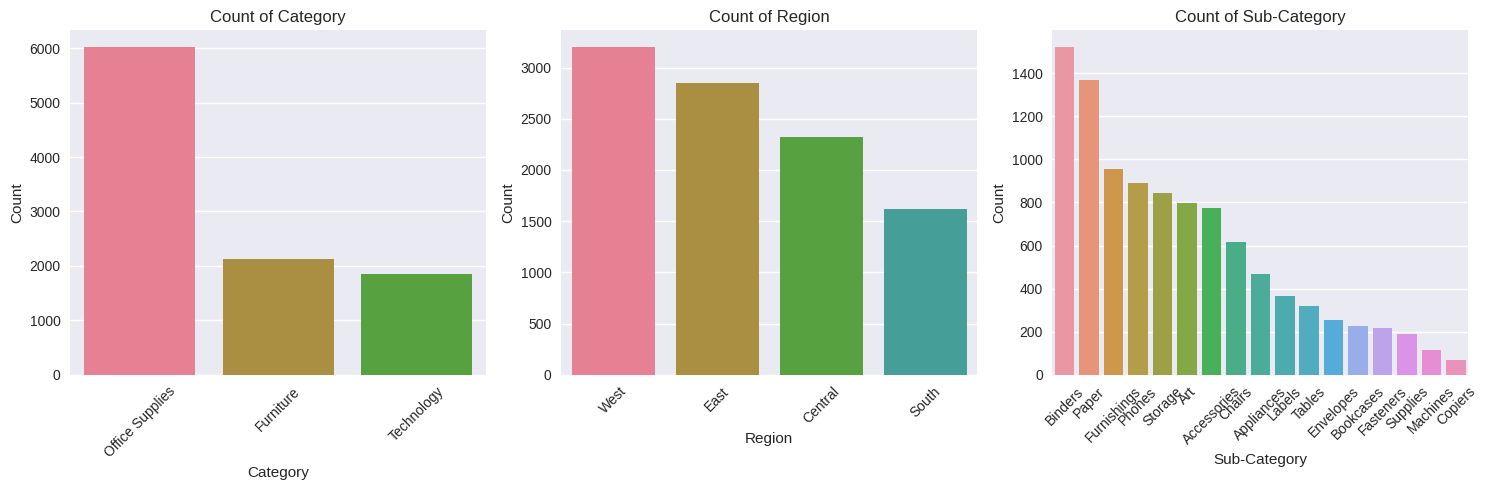

In [88]:
# Categorical Feature Analysis
categorical_features = ['Category', 'Region', 'Sub-Category']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df, x=feature, order=df[feature].value_counts().index)
    plt.title(f'Count of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

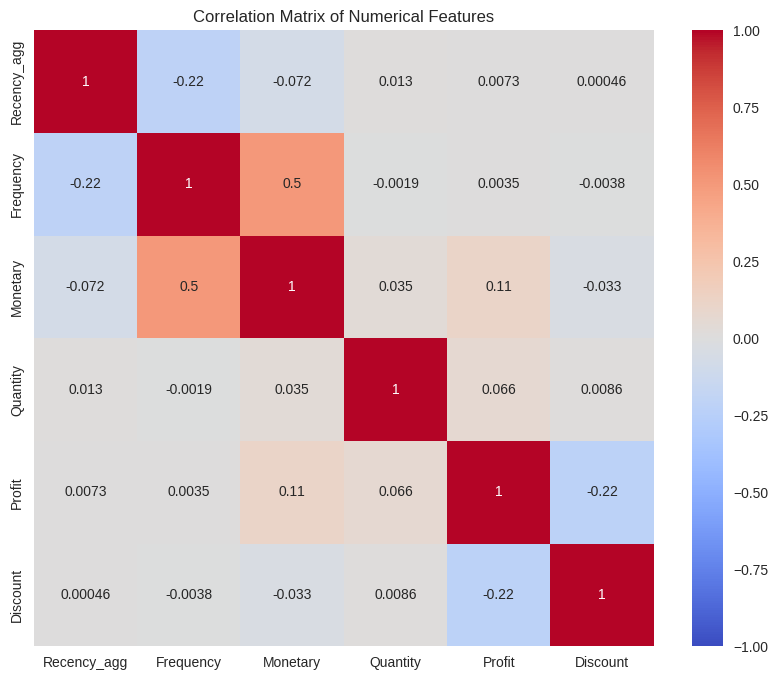

In [89]:
# Correlation Matrix for Numerical Features
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### **Analysis of Results**

**1. Summary Statistics:**

- **Recency_agg:** Mean = 120.28 days, max = 1165 days, indicates a wide range of customer activity levels. High standard deviation (154.84) suggests variability, with a few customers inactive for over a year.
- **Frequency:** Mean = 15.69 orders, max = 37, with a moderate spread (std = 6.65). Most customers (25%-75% percentile: 11-20) have a reasonable purchase frequency.
- **Monetary:** Mean = 3593.96, max = 25,042, with a high std (2838.02), indicates a right-skewed distribution with some high-spending customers (e.g., 75th percentile = $4714 vs. max = 25,042).
- **Quantity:** Mean = 3.79, max = 14, with a narrow range (std = 2.23), suggesting consistent order sizes.
- **Profit:** Mean = 28.65, but with a wide range (-6600 to 8400, std = 234.26), shows significant variability, including substantial losses and gains.
- **Discount:** Mean = 0.156, max = 0.8, with a mode around 0.2 (50th percentile), indicating common discount usage with some outliers at higher values.

**2. Distribution of Numerical Features:**

- **Recency_agg:** Right-skewed, with a peak around 0-200 days, tapering off toward 1165 days. This suggests most customers are relatively recent buyers, with a long tail of inactive ones.
- **Frequency:** Right-skewed, peaking at 10-15 orders, with a long tail up to 37. A few customers have high frequency, which may signify potential loyal segments.
- **Monetary:** Right-skewed, peaking at 0-5000, with a long tail to 25,042. This confirms high-spending outliers (e.g., Adam Bellavance’s 7757).
- **Quantity:** Bimodal, with peaks at 2 and 4-6, and a sharp drop-off beyond 10. This suggests typical order sizes cluster around small to medium quantities.
- **Profit:** Highly skewed, with a spike at 0 and a long tail of negative and positive values. Many transactions are unprofitable, with a few highly profitable ones.
- **Discount:** Bimodal, with peaks at 0 and 0.2, and a decline toward 0.8. Most discounts are either none or 20%, with rare higher discounts.

**3. Scatter Plots for RFM Features:**

- **Recency vs. Monetary (Colored by Frequency):** Higher Monetary values (e.g., >15,000) are associated with lower Recency (recent purchases) and higher Frequency (e.g., 30-36 orders). This suggests a segment of recent, frequent high-spenders.
- **Frequency vs. Monetary (Colored by Recency):** Higher Frequency (e.g., >20) correlates with higher Monetary, especially for low Recency (e.g., 0-200 days). This reinforces the presence of active, high-value customers.
- **Recency vs. Frequency (Colored by Monetary):** Higher Monetary (e.g., >15,000) is linked to lower Recency and moderate to high Frequency (10-25). This indicates potential clusters of loyal, high-value customers.

**4. Categorical Feature Analysis:**

- **Category:** Dominated by Office Supplies, followed by Furniture and Technology. This imbalance may influence cluster formation.
- **Region:** West and East are the largest, followed by Central and South. Regional differences could define customer segments.
- **Sub-Category:** Binders lead, followed by Paper, Furnishings, Phones, and Accessories, with a long tail of less frequent categories (e.g., Copiers). This diversity suggests sub-category preferences may be cluster-relevant.

**5. Correlation Matrix:**

- **Recency_agg:** Weak correlations with other features (e.g., -0.22 with Frequency, -0.072 with Monetary), indicates it’s a relatively independent predictor.
- **Frequency:** Moderate positive correlation with Monetary (0.5), suggests frequent buyers tend to spend more. Weak correlation with Quantity (0.035) and Profit (0.035).
- **Monetary:** Moderate correlation with Frequency (0.5), weak with Quantity (0.035) and Profit (0.11). This means that spending is driven more by frequency than order size or profitability.
- **Quantity:** Strong self-correlation (1), weak with others (e.g., 0.066 with Profit), means it’s a standalone feature.
- **Profit:** Weak correlations overall, with a slight negative correlation with Discount (-0.22). Shows that higher discounts may reduce profitability.
- **Discount:** Weak correlations, with a slight negative link to Profit (-0.22), consistent with the profitability impact.

**6. Key Insights:** 

- Monetary, Profit, and Recency_agg are right-skewed, could signify potential outliers (e.g., high-spenders, unprofitable transactions) that may need handling (e.g., log transformation).
- Scatter plots suggest segments like recent high-spenders (low Recency, high Monetary, high Frequency) and inactive low-spenders (high Recency, low Monetary, low Frequency).
- Office Supplies and West/East regions dominate, which may bias clusters unless balanced.
- Moderate Frequency-Monetary correlation is acceptable for clustering, with no strong multicollinearity to remove features.

## Clustering Model Development

In [91]:
# Use scaled_df from preprocessing
X = scaled_df

In [92]:
# Determine optimal number of clusters using elbow method
inertia = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

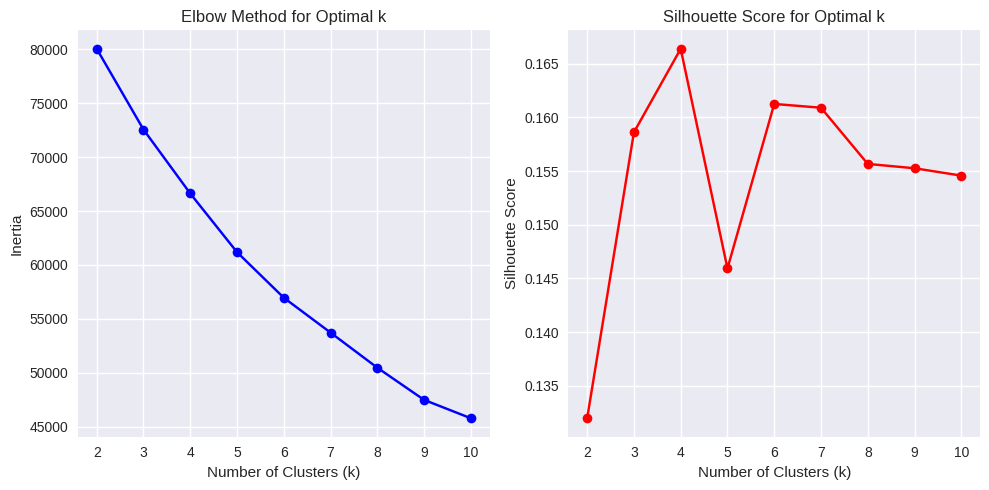

In [93]:
# Plot elbow curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

Let’s examine the two plots to determine the best k: 

- **Elbow Method:** The plot shows inertia decreasing as the number of clusters (k) increases. The "elbow" is the point where the rate of decrease slows significantly. Here, the curve starts flattening around k=4 to k=5. The drop from k=4 to k=5 is less pronounced than earlier, suggesting k=4 as a potential elbow point.
- **Silhouette Score:** The silhouette score measures cluster cohesion and separation, with higher values indicating better-defined clusters. The plot peaks at k=3 with a score around 0.165, then dips and fluctuates slightly, dropping to around 0.140 by k=10. The peak at k=3 suggests it might yield the most well-separated clusters, but k=4 (around 0.155) is also reasonable and aligns with the elbow method.
  
**Best k:** While k=3 has the highest silhouette score, the elbow method suggests k=4 as a good balance between cluster simplicity and variance explained. Since K-Means benefits from a slightly higher k to capture nuanced segments, we'll go with **optimal k=4** for the next section, but may need to reconsider during hyperparameter tuning.

In [94]:
# Fit K-Means with the optimal k=4
optimal_k = 4  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)

In [95]:
# Add cluster labels to the original dataframe
df['Cluster'] = cluster_labels

In [96]:
# Display cluster distribution
print("\nCluster Distribution:")
print(df['Cluster'].value_counts())


Cluster Distribution:
Cluster
2    5605
1    2374
0    1085
3     930
Name: count, dtype: int64


In [97]:
# Display first few rows with cluster labels
print("\nDataFrame with Cluster Labels (First 5 Rows):")
print(df[['Customer Name', 'Recency_agg', 'Frequency', 'Monetary', 'Cluster']].head())


DataFrame with Cluster Labels (First 5 Rows):
   Customer Name  Recency_agg  Frequency  Monetary  Cluster
0  Darren Powers          126         17    1051.0        2
1  Phillina Ober           86         10    1057.0        2
2  Phillina Ober           86         10    1057.0        2
3  Phillina Ober           86         10    1057.0        0
4     Mick Brown           44         10    1429.0        2


#### **Analysis of Results**

**1. Cluster Distribution:**

- **Cluster 2:** 5605 customers (largest cluster), likely representing the most common customer profile in the dataset.
- **Cluster 1:** 2374 customers, a significant but smaller group compared to Cluster 2.
- **Cluster 0:** 1085 customers, a moderately sized cluster.
- **Cluster 3:** 930 customers (smallest cluster), potentially representing a niche or outlier group.
- The distribution is uneven, with Cluster 2 dominating (over 56% of the data). This imbalance could be due to a prevalent customer type (e.g., frequent buyers of Office Supplies, as seen in the EDA). However, the smaller clusters (0, 1, 3) may still capture distinct behaviors, which we’ll explore in the next section.

**3. DataFrame with Cluster Labels (First 5 Rows):**

- **Darren Powers (Cluster 2):** Recency_agg = 126 days, Frequency = 17, Monetary = 1051. This customer is moderately recent, with above-average frequency (mean = 15.69) but below-average spending (mean = 3593.96).
- **Phillina Ober (Cluster 2, rows 1-2):** Recency_agg = 86 days, Frequency = 10, Monetary = 1057. Similar to Darren, Phillina is more recent (86 days vs. mean = 120.28) but has lower frequency (10 vs. mean = 15.69) and spending.
- **Phillina Ober (Cluster 0, row 3):** Same RFM metrics as rows 1-2, but assigned to Cluster 0. This suggests that other features (e.g., Discount, Category_Encoded) may differ between these rows, influencing the cluster assignment.
- **Mick Brown (Cluster 2):** Recency_agg = 44 days, Frequency = 10, Monetary = 1429. Mick is more recent (44 days) with slightly higher spending than Phillina and Darren, but the same frequency (10). Being in Cluster 2 suggests similarity to Darren and Phillina in overall behavior.
- **Initial Observation:** Cluster 2 seems to capture customers with moderate recency (44-126 days), lower-to-moderate frequency (10-17), and lower monetary values (1051-1429). Cluster 0’s assignment for Phillina (row 3) indicates that features beyond RFM (e.g., Profit, Discount, or categorical variables) may be driving the separation.
  
**4. Potential Patterns:**

- **Cluster 2 Dominance:** Likely represents the “average” customer—moderate recency, frequency, and spending, possibly dominated by Office Supplies purchases (as seen in EDA, where Office Supplies had ~5000 counts).
- **Cluster 0 vs. Cluster 2:** Phillina’s split between Cluster 0 and Cluster 2 suggests that transactional features (e.g., Profit, Discount, or Sub-Category) may differ across her orders, leading to different cluster assignments despite identical RFM metrics.
- **Smaller Clusters (0, 1, 3):** These may represent niche segments, such as high-value recent buyers (low recency, high monetary, high frequency) or inactive low-spenders (high recency, low monetary), which we’ll confirm in the cluster analysis section.

**5. Model Quality:**

- The silhouette score at k=4 (0.155) is relatively low, indicating some overlap between clusters. This is common in retail datasets with continuous features like RFM, where customer behaviors may not be perfectly separable.
- The uneven cluster distribution suggests potential improvements 

In [98]:
# Use df_copy for hyperparameter tuning
df_tune = df_copy.copy()

In [99]:
# Apply log transformation to Monetary to reduce skewness
df_tune['Monetary'] = np.log1p(df_tune['Monetary'])  # log1p handles zero values

In [100]:
# Re-scale features after transformation
features = ['Recency_agg', 'Frequency', 'Monetary', 'Quantity', 'Profit', 'Discount', 
            'Category_Encoded', 'Region_Encoded', 'Sub-Category_Encoded']
scaler = StandardScaler()
scaled_features_tune = scaler.fit_transform(df_tune[features])
scaled_df_tune = pd.DataFrame(scaled_features_tune, columns=features)

In [101]:
# Test different n_init values for K-Means stability
n_init_values = [10, 20, 30]
optimal_k = 4  # From previous step
silhouette_scores_n_init = []

for n_init in n_init_values:
    kmeans = KMeans(n_clusters=optimal_k, n_init=n_init, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_df_tune)
    score = silhouette_score(scaled_df_tune, cluster_labels)
    silhouette_scores_n_init.append(score)
    print(f"Silhouette Score for n_init={n_init}: {score}")

Silhouette Score for n_init=10: 0.13436758805323468
Silhouette Score for n_init=20: 0.13648763579653306
Silhouette Score for n_init=30: 0.13648763579653306


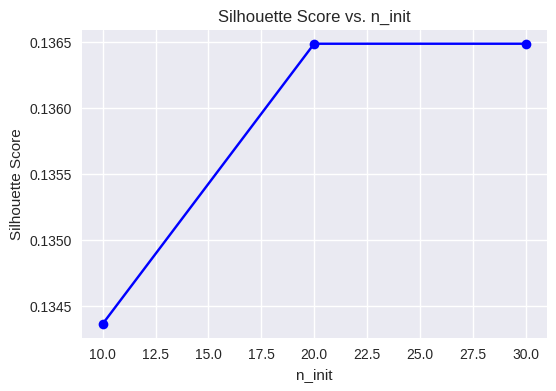

In [102]:
# Plot silhouette scores for different n_init values
plt.figure(figsize=(6, 4))
plt.plot(n_init_values, silhouette_scores_n_init, 'bo-')
plt.xlabel('n_init')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. n_init')
plt.grid(True)
plt.show()

In [103]:
# Fit K-Means with the best n_init = 20
best_n_init = 20  
kmeans_tuned = KMeans(n_clusters=optimal_k, n_init=best_n_init, random_state=42)
cluster_labels_tuned = kmeans_tuned.fit_predict(scaled_df_tune)

In [104]:
# Add tuned cluster labels to df_tune
df_tune['Cluster'] = cluster_labels_tuned

In [105]:
# Display cluster distribution after tuning
print("\nTuned Cluster Distribution:")
print(df_tune['Cluster'].value_counts())


Tuned Cluster Distribution:
Cluster
0    4069
1    2570
3    2348
2    1007
Name: count, dtype: int64


In [106]:
# Display first few rows with tuned cluster labels
print("\nDataFrame with Tuned Cluster Labels (First 5 Rows):")
print(df_tune[['Customer Name', 'Recency_agg', 'Frequency', 'Monetary', 'Cluster']].head())


DataFrame with Tuned Cluster Labels (First 5 Rows):
   Customer Name  Recency_agg  Frequency  Monetary  Cluster
0  Darren Powers          126         17  6.958448        1
1  Phillina Ober           86         10  6.964136        1
2  Phillina Ober           86         10  6.964136        1
3  Phillina Ober           86         10  6.964136        2
4     Mick Brown           44         10  7.265430        3


#### **Analysis of Results**

**1. Tuned Cluster Distribution:**

- **Cluster 0:** 4069 customers (largest cluster, 40.7% of the data).
- **Cluster 1:** 2570 customers (25.7%).
- **Cluster 3:** 2348 customers (23.5%).
- **Cluster 2:** 1007 customers (smallest cluster, 10.1%).
- Compared to the initial clustering (Cluster 2: 5605, Cluster 1: 2374, Cluster 0: 1085, Cluster 3: 930), the tuned distribution is more balanced. The largest cluster (Cluster 0) now holds 40.7% of the data (down from 56% in Cluster 2), and the smallest cluster (Cluster 2) has 10.1% (up from 9.3% in Cluster 3). This suggests the log transformation helped distribute customers more evenly by reducing the dominance of extreme Monetary values.
  
**2. DataFrame with Tuned Cluster Labels (First 5 Rows):**

- **Darren Powers (Cluster 1):** Recency_agg = 126 days, Frequency = 17, Monetary = 6.958448 (originally 1051). Moderately recent, above-average frequency (mean = 15.69), and below-average spending (mean before log = 3593.96).
- **Phillina Ober (Cluster 1, rows 1-2):** Recency_agg = 86 days, Frequency = 10, Monetary = 6.964136 (originally 1057). More recent than Darren, with lower frequency and similar spending.
- **Phillina Ober (Cluster 2, row 3):** Same RFM metrics as rows 1-2 but assigned to Cluster 2. This indicates other features (e.g., Discount, Profit, or categorical variables like Sub-Category) differ in this transaction, influencing the cluster assignment.
- **Mick Brown (Cluster 3):** Recency_agg = 44 days, Frequency = 10, Monetary = 7.265430 (originally $1429). More recent, with slightly higher spending than Phillina and Darren, but the same frequency.
- **Initial Observation:** Cluster 1 seems to capture customers with moderate recency (86-126 days) and lower-to-moderate spending, similar to the initial Cluster 2. Cluster 2’s assignment for Phillina (row 3) suggests a niche group, possibly defined by transactional features. Cluster 3 (Mick Brown) may represent more recent buyers.
  
**3. Impact of Tuning:**

- Log Transformation likely improved the clustering of high-spending customers by reducing the skew of Monetary, which led to a more balanced cluster distribution.
- For n_init tuning, the increase in silhouette score from 0.1344 to 0.1365 with n_init=20 indicates a more stable solution, though the overall score remains modest, suggesting some cluster overlap.
- Cluster Reassignment: Phillina’s split between Cluster 1 and Cluster 2 mirrors the initial clustering (Cluster 2 and Cluster 0), but the more balanced distribution suggests the tuned model captures more distinct segments.

## Cluster Analysis and Interpretation

In [107]:
# Use df_tune with tuned cluster labels
df_analysis = df_tune

In [108]:
# Summary statistics for each cluster (RFM, Profit, Discount)
cluster_summary = df_analysis.groupby('Cluster').agg({
    'Recency_agg': ['mean', 'min', 'max'],
    'Frequency': ['mean', 'min', 'max'],
    'Monetary': ['mean', 'min', 'max'],  # Note: This is log-transformed
    'Profit': ['mean', 'min', 'max'],
    'Discount': ['mean', 'min', 'max'],
    'Cluster': 'count'
}).round(2)

print("\nCluster Summary Statistics:")
print(cluster_summary)


Cluster Summary Statistics:
        Recency_agg           Frequency         Monetary               Profit  \
               mean min   max      mean min max     mean   min    max    mean   
Cluster                                                                         
0             73.69   0   581     18.52   3  37     8.29  6.96  10.13   31.00   
1            230.88   0  1165      9.58   1  22     7.01  1.79   9.26   20.35   
2            108.90   0  1035     15.91   3  37     7.88  3.91  10.13 -104.17   
3             84.85   0   835     17.39   3  37     8.15  6.12  10.13   90.63   

                        Discount           Cluster  
            min     max     mean  min  max   count  
Cluster                                             
0       -1049.0  1228.0     0.10  0.0  0.5    4069  
1        -538.0   945.0     0.11  0.0  0.7    2570  
2       -6600.0     0.0     0.66  0.3  0.8    1007  
3         -76.0  8400.0     0.09  0.0  0.4    2348  


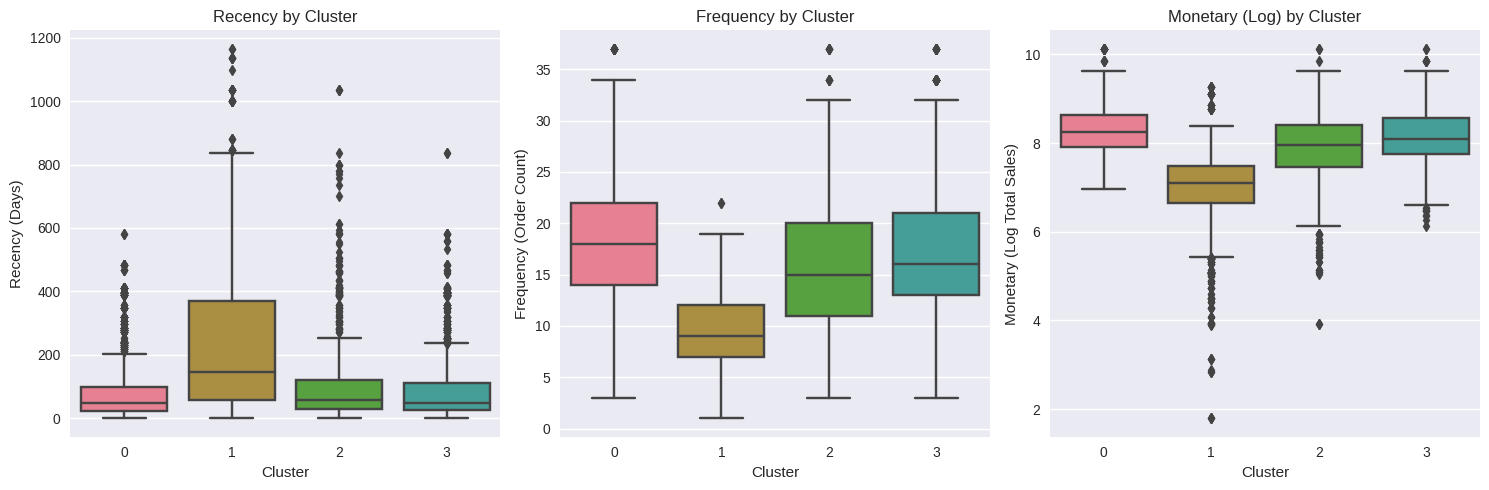

In [109]:
# Visualize RFM distributions across clusters
plt.figure(figsize=(15, 5))

# Recency
plt.subplot(1, 3, 1)
sns.boxplot(x='Cluster', y='Recency_agg', data=df_analysis)
plt.title('Recency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency (Days)')

# Frequency
plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=df_analysis)
plt.title('Frequency by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency (Order Count)')

# Monetary (log-transformed)
plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=df_analysis)
plt.title('Monetary (Log) by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary (Log Total Sales)')

plt.tight_layout()
plt.show()

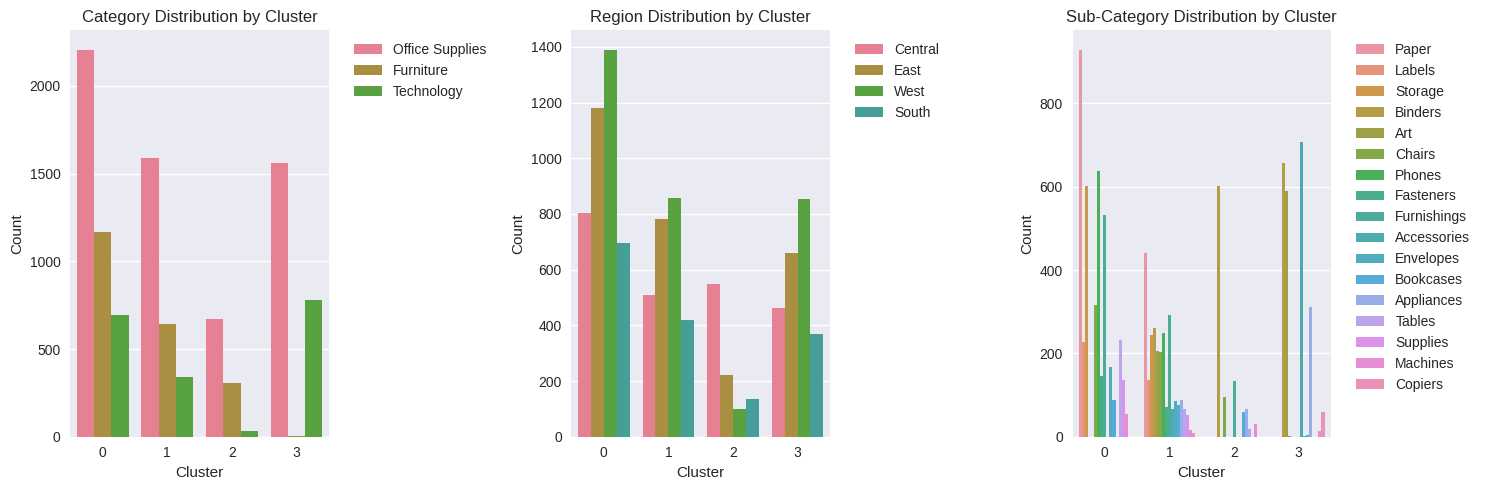

In [110]:
# Categorical feature distributions by cluster
categorical_features = ['Category', 'Region', 'Sub-Category']
plt.figure(figsize=(15, 5))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(1, 3, i)
    sns.countplot(data=df_analysis, x='Cluster', hue=feature)
    plt.title(f'{feature} Distribution by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### **Analysis of Results**

**1. Cluster Summary Statistics:**

- **Cluster 0 (4069 customers, 40.7%):**
    - **Recency_agg:** Mean = 73.69 days, min = 0, max = 581. This cluster includes relatively recent customers, with most purchases within the last 2-3 months.
    **Frequency:** Mean = 18.52, min = 3, max = 37. High frequency, indicating loyal or frequent buyers.
    - **Monetary (log):** Mean = 8.29 (original 4000-5000), min = 6.96 (1000), max = 10.13 (25,000). Above-average spending, with some high-value customers.
    - **Profit:** Mean = 31.00, range = -$1049 to $1228. Moderately profitable, with a mix of gains and losses.
    - **Discount:** Mean = 0.10, range = 0.0-0.5. Low discount usage.
    - **Profile:** Recent, frequent, high-spending customers with moderate profitability and low discounts. Likely a valuable segment.
- **Cluster 1 (2570 customers, 25.7%):**
    - **Recency_agg:** Mean = 230.88 days, min = 0, max = 1165. This cluster includes less recent customers, with many inactive for 6-12 months.
    - **Frequency:** Mean = 9.58, min = 1, max = 22. Low to moderate frequency, suggesting occasional buyers.
    - **Monetary (log):** Mean = 7.01 (original 1100), min = 1.79, max = 9.26. Below-average spending, with a wide range including very low spenders.
    - **Profit:** Mean = 20.35, range = -538 to 945. Slightly profitable on average, with moderate variability.
    - **Discount:** Mean = 0.11, range = 0.0-0.7. Low to moderate discount usage.
    - **Profile:** Inactive, occasional buyers with lower spending and moderate profitability. Likely a less engaged segment.
- **Cluster 2 (1007 customers, 10.1%):**
    - **Recency_agg:** Mean = 108.90 days, min = 0, max = 1035. Moderately recent, with some inactive customers.
    - **Frequency:** Mean = 15.91, min = 3, max = 37. Moderate to high frequency, indicating regular buyers.
    - **Monetary (log):** Mean = 7.88, min = 3.91, max = 10.13. Below-average spending with some high spenders.
    - **Profit:** Mean = -104.17, range = -6600 to 0. Unprofitable, with significant losses.
    - **Discount:** Mean = 0.66, range = 0.3-0.8. High discount usage.
    - **Profile:** Moderately recent, regular buyers with below-average spending, high discounts, and consistent unprofitability. Likely a problematic segment.
- **Cluster 3 (2348 customers, 23.5%):**
    - **Recency_agg:** Mean = 84.85 days, min = 0, max = 835. Recent customers, similar to Cluster 0 but with a wider range.
    - **Frequency:** Mean = 17.39, min = 3, max = 37. High frequency, comparable to Cluster 0.
    - **Monetary (log):** Mean = 8.15, min = 6.12, max = 10.13. Above-average spending, with some high-value customers.
    - **Profit:** Mean = 90.63, range = -76 to 8400. Highly profitable, with significant gains.
    - **Discount:** Mean = 0.09, range = 0.0-0.4. Very low discount usage.
    - **Profile:** Recent, frequent, high-spending customers with high profitability and minimal discounts. Likely the most valuable segment.
      
**2. Boxplots (Recency, Frequency, Monetary by Cluster):**

- **Recency:** Cluster 1 has the highest median (around 200-250 days), indicating inactivity, while Clusters 0 and 3 have lower medians (around 50-100 days), showing recent activity. Cluster 2 falls in between (around 100 days). Outliers extend to 1000+ days in Clusters 1 and 2.
- **Frequency:** Clusters 0 and 3 have higher medians (around 18-20), reflects frequent buyers, while Cluster 1 has a lower median (around 9-10), and Cluster 2 is intermediate (around 15-16). Outliers reach up to 35-37 across all clusters.
- **Monetary (Log):** Clusters 0 and 3 have higher medians (around 8-8.5, or 3000-5000), indicates higher spending, while Cluster 1 has a lower median (around 7, or 1100), and Cluster 2 is intermediate (around 7.5-8, or 1800-2700). Outliers extend to 10+ in all clusters, though less pronounced after log transformation.
-**Insight:** The log transformation has compressed the monetary scale, making cluster differences more apparent. Clusters 0 and 3 are high-value, while Cluster 1 is low-value, and Cluster 2 shows moderate spending with profitability issues.

**3. Categorical Feature Distributions by Cluster:**

- **Category:** All clusters are dominated by Office Supplies (e.g., 1500-2000 counts), with Furniture and Technology as secondary categories. Cluster 0 has the highest Office Supplies count, while Cluster 2 shows a more balanced mix, possibly due to higher discount usage across categories.
- **Region:** West and East dominate all clusters (e.g., 800-1200 counts), with Central and South as secondary. Cluster 0 has the highest West count, while Cluster 2 shows a more even regional spread, possibly reflecting broader discount-driven sales.
- **Sub-Category:** Binders, Paper, and Furnishings are prevalent across all clusters (e.g., 400-800 counts). Cluster 0 and 3 lean toward Binders and Paper, while Cluster 2 shows a wider spread (e.g., higher Labels and Storage), possibly linked to high discounts. Cluster 1 has a more uniform distribution, reflecting its inactive nature.
- **Insight:** The dominance of Office Supplies and West/East regions aligns with EDA findings. Cluster 2’s broader sub-category spread and high discounts suggest it includes discount-driven or unprofitable product lines.

**4. Key Patterns:**

- **Valuable Segments:** Cluster 0 (recent, frequent, high-spending, profitable) and Cluster 3 (recent, frequent, high-spending, highly profitable) are the most valuable, likely representing loyal high-value customers.
- **Problematic Segment:** Cluster 2 (moderately recent, regular, moderate-spending, unprofitable, high discounts) indicates a loss-making group, possibly due to excessive discounting.
- **Inactive Segment:** Cluster 1 (inactive, occasional, low-spending, moderately profitable) represents a less engaged group that may need re-engagement strategies.

## Business Insights and Recommendations

Let’s translate the findings into actionable business insights and recommendations based on the cluster analysis. We do this to optimize marketing, inventory, and customer retention strategies.

1. Identify and prioritize high-value segments

    - Clusters 0 and 3 are recent, frequent, high-spending, and profitable customers. They contribute significantly to revenue and profit.
    - **Recommendation:** Develop loyalty programs targeting Clusters 0 and 3 that offer exclusive discounts or premium products. Increase inventory for popular sub-categories (e.g., Binders, Paper) in West and East regions to meet their demand.
      
2. Address unprofitable segment

    - Cluster 2 shows unprofitability (mean profit = -104.17) despite moderate activity, driven by high discounts (mean = 0.66).
    - **Recommendation:** Review pricing strategies for Cluster 2 by reducing discounts (e.g., cap at 0.3) and analyzing sub-categories like Labels and Storage for cost inefficiencies. Target these customers with value-added services instead of discounts to improve profitability.

3. Re-engage inactive customers

    - Cluster 1 includes inactive, low-spending customers (mean recency = 230.88 days) with moderate profitability.
    - **Recommendation:** Launch re-engagement campaigns for Cluster 1, offering personalized promotions (e.g., 10% off first order after 6 months) to reactivate them. Focus on West and East regions, where they are concentrated.

4. Optimize inventory and marketing

    - Office Supplies dominate all clusters, with Binders and Paper as key sub-categories. West and East regions drive sales.
    - **Recommendation:** Prioritize stock for Office Supplies (especially Binders, Paper) in West and East. Tailor marketing campaigns to regional preferences, highlighting these products for Clusters 0 and 3, while testing new offerings for Cluster 2 to shift it toward profitability.
   
**Overall Strategy:**

- Focus resources on Clusters 0 and 3 for growth, mitigate losses in Cluster 2 through pricing adjustments, and invest in re-engagement for Cluster 1. Monitor profit trends post-implementation to refine strategies.